# Resampling data

This notebook will demonstrate how to resample data with Lilio.
Lilio is able to resample Pandas' `DataFrame` and `Series`, as well as xarray's `DataArray` and `Dataset`.

We start by importing the required libraries and generating an example Pandas Series and a DataFrame

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import lilio

time_index = pd.date_range('20171020', '20211001', freq='15d')
random_data = np.random.random(len(time_index))
example_series = pd.Series(random_data, index=time_index)
example_dataframe = pd.DataFrame(example_series.rename('data1'))
example_dataframe['data2'] = example_dataframe['data1']

example_series.head(3)

2017-10-20    0.853260
2017-11-04    0.458634
2017-11-19    0.127702
Freq: 15D, dtype: float64

The DataFrame looks similar but has two named columns:

In [2]:
example_dataframe.head(3)

,data1,data2
2017-10-20,0.853260,0.853260
2017-11-04,0.458634,0.458634
2017-11-19,0.127702,0.127702


To resample we need to set up an calendar with the anchor date and frequency.
In this case we choose to use the `daily_calendar` shorthand.

(Passing `max_lag` is optional, as well as `allow_overlap`, but this will allow us to demonstrate that resampling works even when intervals overlap)

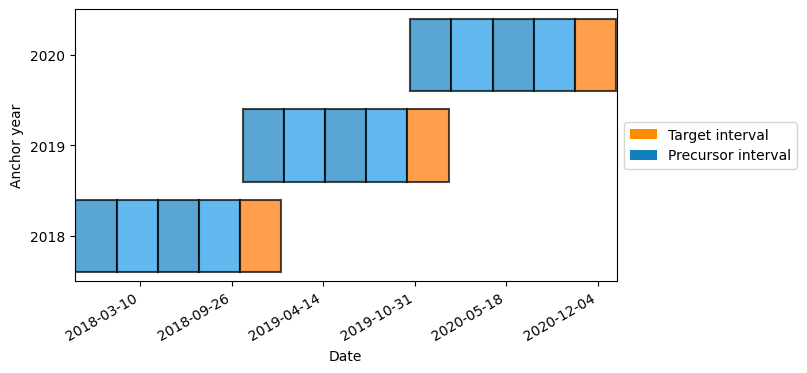

In [3]:
calendar = lilio.daily_calendar(
    anchor="10-15",
    length='90d',
    n_precursors=4,
    allow_overlap=True
)
calendar.map_years(2018, 2020)
calendar.visualize()

Next we pass the example data to the `resample` function. This requires a mapped calendar and the input data.

By default, `resample` will take the mean of all datapoints that fall within each interval. However, many other statistics are available, such as `min`, `max`, `median`, `std`, etc. For a full list see the docstring with:
```py
help(lilio.resample)
```

In [4]:
resampled_series = lilio.resample(calendar, example_series, how="mean")
resampled_series

,anchor_year,i_interval,interval,data,target
0,2018,-4,"[2017-10-20, 2018-01-18)",0.369219,False
1,2018,-3,"[2018-01-18, 2018-04-18)",0.678042,False
2,2018,-2,"[2018-04-18, 2018-07-17)",0.304581,False
3,2018,-1,"[2018-07-17, 2018-10-15)",0.600108,False
4,2018,1,"[2018-10-15, 2019-01-13)",0.423860,True
5,2019,-4,"[2018-10-20, 2019-01-18)",0.458997,False
6,2019,-3,"[2019-01-18, 2019-04-18)",0.357288,False
7,2019,-2,"[2019-04-18, 2019-07-17)",0.717173,False
8,2019,-1,"[2019-07-17, 2019-10-15)",0.566432,False
9,2019,1,"[2019-10-15, 2020-01-13)",0.616007,True


As you see above, this generates a new DataFrame containing the data resampled for each interval, along with the corresponding interval index, and the anchor year that the interval belongs to.

This works the same if you input a pandas DataFrame:

In [5]:
resampled_dataframe = lilio.resample(calendar, example_dataframe)
resampled_dataframe

,anchor_year,i_interval,interval,data1,data2,target
0,2018,-4,"[2017-10-20, 2018-01-18)",0.369219,0.369219,False
1,2018,-3,"[2018-01-18, 2018-04-18)",0.678042,0.678042,False
2,2018,-2,"[2018-04-18, 2018-07-17)",0.304581,0.304581,False
3,2018,-1,"[2018-07-17, 2018-10-15)",0.600108,0.600108,False
4,2018,1,"[2018-10-15, 2019-01-13)",0.423860,0.423860,True
5,2019,-4,"[2018-10-20, 2019-01-18)",0.458997,0.458997,False
6,2019,-3,"[2019-01-18, 2019-04-18)",0.357288,0.357288,False
7,2019,-2,"[2019-04-18, 2019-07-17)",0.717173,0.717173,False
8,2019,-1,"[2019-07-17, 2019-10-15)",0.566432,0.566432,False
9,2019,1,"[2019-10-15, 2020-01-13)",0.616007,0.616007,True


## Resampling `xarray` data

Resampling works the same for an `xarray` `Dataset`. Let's make an example dataset with latitude and longitude coordinates:

In [6]:
import xarray as xr

time_index = pd.date_range('20171020', '20211001', freq='15d')

np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, len(time_index))
precipitation = 10 * np.random.rand(2, 2, len(time_index))

lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]


ds = xr.Dataset(
    data_vars=dict(
        temperature=(["x", "y", "time"], temperature),
        precipitation=(["x", "y", "time"], precipitation),
    ),
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=time_index,
    ),
    attrs=dict(description="Weather related data."),
)
ds

<xarray.Dataset>
Dimensions:        (x: 2, y: 2, time: 97)
Coordinates:
    lon            (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat            (x, y) float64 42.25 42.21 42.63 42.59
  * time           (time) datetime64[ns] 2017-10-20 2017-11-04 ... 2021-09-29
Dimensions without coordinates: x, y
Data variables:
    temperature    (x, y, time) float64 29.11 18.2 22.83 ... 1.746 7.116 3.225
    precipitation  (x, y, time) float64 5.25 7.506 3.335 ... 7.359 1.415 8.659
Attributes:
    description:  Weather related data.

As you see below, the `temperature` and `precipitation` variables can 
easily be resampled to a new index using the calendar specified intervals.

This index dimension has as coordinates the anchor year and the interval count.



Note: both the `temperature` and `precipitation` variables have kept their 
`lat` and `lon` coordinates.

In [7]:
lilio.resample(calendar, ds["temperature"])

<xarray.DataArray 'temperature' (anchor_year: 3, i_interval: 5, x: 2, y: 2)>
array([[[[23.36549446, 17.10623812],
         [22.26238524, 17.48205385]],

        [[18.60590392, 18.33568363],
         [15.22605039, 16.04933376]],

        [[18.93222815, 21.71327241],
         [15.86241907, 11.71770969]],

        [[11.90916256, 19.67654646],
         [14.10339232, 13.05611392]],

        [[19.9014688 , 13.99448977],
         [16.24401403, 13.5023425 ]]],


       [[[17.08172587, 17.92604246],
         [11.17720608, 12.29254973]],

        [[13.06441041, 15.27545014],
...
         [12.1541231 , 11.82364142]],

        [[11.74543481, 15.09573755],
         [13.84770432, 12.32257394]]],


       [[[11.74543481, 15.09573755],
         [13.84770432, 12.32257394]],

        [[13.83706304, 11.95144032],
         [13.65735477, 13.02433449]],

        [[ 8.66195308, 16.17757727],
         [10.23249271, 11.2407416 ]],

        [[17.13987126, 13.10521789],
         [11.8275895 , 17.81965851]],

        [[10.62867518, 16.4569909 ],
         [14.27640264, 12.55199757]]]])
Coordinates:
  * anchor_year  (anchor_year) int64 2018 2019 2020
  * i_interval   (i_interval) int64 -4 -3 -2 -1 1
  * x            (x) int64 0 1
  * y            (y) int64 0 1
    target       (i_interval) bool False False False False True

In [8]:
ds_r = lilio.resample(calendar, ds)
ds_r

<xarray.DataArray 'temperature' (anchor_year: 3, i_interval: 5, x: 2, y: 2)>
array([[[[23.36549446, 17.10623812],
         [22.26238524, 17.48205385]],

        [[18.60590392, 18.33568363],
         [15.22605039, 16.04933376]],

        [[18.93222815, 21.71327241],
         [15.86241907, 11.71770969]],

        [[11.90916256, 19.67654646],
         [14.10339232, 13.05611392]],

        [[19.9014688 , 13.99448977],
         [16.24401403, 13.5023425 ]]],


       [[[17.08172587, 17.92604246],
         [11.17720608, 12.29254973]],

        [[13.06441041, 15.27545014],
...
         [12.1541231 , 11.82364142]],

        [[11.74543481, 15.09573755],
         [13.84770432, 12.32257394]]],


       [[[11.74543481, 15.09573755],
         [13.84770432, 12.32257394]],

        [[13.83706304, 11.95144032],
         [13.65735477, 13.02433449]],

        [[ 8.66195308, 16.17757727],
         [10.23249271, 11.2407416 ]],

        [[17.13987126, 13.10521789],
         [11.8275895 , 17.81965851]],

        [[10.62867518, 16.4569909 ],
         [14.27640264, 12.55199757]]]])
Coordinates:
  * anchor_year  (anchor_year) int64 2018 2019 2020
  * i_interval   (i_interval) int64 -4 -3 -2 -1 1
  * x            (x) int64 0 1
  * y            (y) int64 0 1
    target       (i_interval) bool False False False False True

## Calculating bin counts
To check if you have sufficient data for each of the Calendar's intervals, you can make use of `resample(how="size")`. This will give you the number of data points that are within each interval.

Especially when the intervals are of varying sizes, or your data is more sparse, then this can be very useful.

As an example, let's make a calendar with varyingly sized intervals:

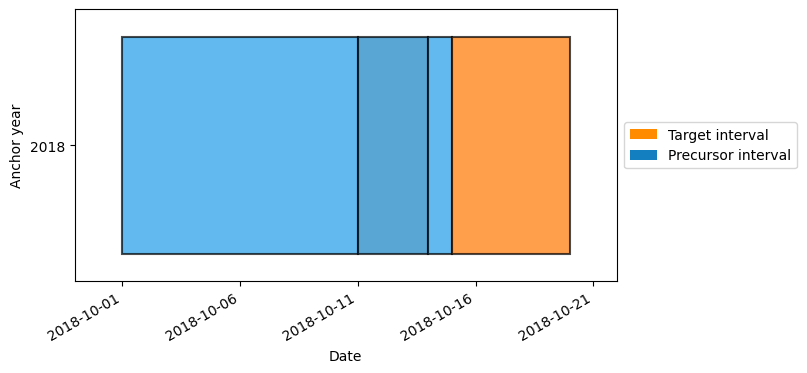

In [9]:
calendar = lilio.Calendar(anchor="10-15")
calendar.add_intervals("target", length="5d")
calendar.add_intervals("precursor", length="1d")
calendar.add_intervals("precursor", length="3d")
calendar.add_intervals("precursor", length="10d")
calendar.map_years(2018, 2018)
calendar.visualize()

Now if we resample a dataset with a 1-day frequency, using `how="size"`, you can see that the smallest interval contains only a single data point, while the largest interval contains ten.

Some of the resampling methods (such as "min" or "std") of course would not make sense with such few data points per interval.

In [10]:
time_index = pd.date_range('20171020', '20191001', freq='1d')
random_data = np.random.random(len(time_index))
example_series = pd.Series(random_data, index=time_index)
example_dataframe = pd.DataFrame(example_series.rename('data1'))

lilio.resample(calendar, example_dataframe, how="size")

,anchor_year,i_interval,interval,data1,target
0,2018,-3,"[2018-10-01, 2018-10-11)",10.0,False
1,2018,-2,"[2018-10-11, 2018-10-14)",3.0,False
2,2018,-1,"[2018-10-14, 2018-10-15)",1.0,False
3,2018,1,"[2018-10-15, 2018-10-20)",5.0,True


## Custom resampling methods
The `how` argument also accepts any function with a single input and a single output argument. This allows you to use custom defined functions to resample the data. 

For example:

In [11]:
def root_mean_squared(data):
    return np.mean(data ** 2) ** 0.5

lilio.resample(calendar, example_dataframe, how=root_mean_squared)

,anchor_year,i_interval,interval,data1,target
0,2018,-3,"[2018-10-01, 2018-10-11)",0.516371,False
1,2018,-2,"[2018-10-11, 2018-10-14)",0.714292,False
2,2018,-1,"[2018-10-14, 2018-10-15)",0.363845,False
3,2018,1,"[2018-10-15, 2018-10-20)",0.686525,True
